# MobileNet v3 - OpenCV

Using pre-trained model available from [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).
All model trained using the Object Detection API could be used for inference using OpenCV.

**Attention**: This setup requires having latest OpenCV version (https://github.com/opencv/opencv/archive/4.3.0.zip) and it needs to be build from the source. Follow `Building OpenCV from source` in https://docs.opencv.org/4.3.0/d2/de6/tutorial_py_setup_in_ubuntu.html

**Or use the docker image provided, it has all requirements installed**



In [1]:
# Get weights & config
#!mkdir mobilenet_v3_files

#!wget -O ./mobilenet_v3_files/graph.pbtxt https://www.dropbox.com/s/dfn0sb43ovb8pr0/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt?dl=1
#!wget -O ./mobilenet_v3_files/frozen_inference_graph.pb https://www.dropbox.com/s/ardvflqmwwe8uzl/frozen_inference_graph.pb?dl=1

## Load libraries 

In [2]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
print(cv2.__version__)

4.3.0


## Load the model (pre-trained)

In [4]:
# Tensorflow models are trained with 90 classes (10 empty)
classes = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
    11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
    16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow',
    22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack',
    28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee',
    35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite',
    39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard',
    43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork',
    49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple',
    54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog',
    59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch',
    64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv',
    73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone',
    78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink', 82: 'refrigerator',
    84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear',
    89: 'hair drier', 90: 'toothbrush',
}

model_weights = 'mobilenet_v3_files/frozen_inference_graph.pb'
model_graph = 'mobilenet_v3_files/graph.pbtxt'

# Load pretrained weights 
net = cv2.dnn_DetectionModel('mobilenet_v3_files/frozen_inference_graph.pb', 'mobilenet_v3_files/graph.pbtxt')

# set opencv backend and CPU inference
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

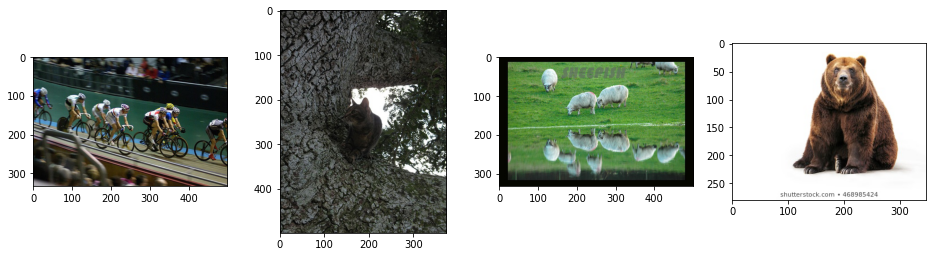

In [5]:
# show images
IMG_PATHS = [
    './images/img1.jpg',
    './images/img2.jpg',
    './images/img3.jpg',
    './images/img4.jpg',
]

plt.figure(figsize=(16, 9))

for img in IMG_PATHS:
    image = mpimg.imread(img)
    plt.subplot(2, 4, IMG_PATHS.index(img)+1)
    plt.imshow(image)

## Inference

In [6]:
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

def mobilenetv3_inference(img, model):
    """
    A function that takes an image and a mobilenet model and return outputs of the model 
    img: str to the path
    model: loaded model
    """
    # Define the input
    input_img = cv2.imread(img)
    model.setInputSize(320, 320)
    model.setInputScale(1.0 / 127.5)
    model.setInputMean((127.5, 127.5, 127.5))
    model.setInputSwapRB(True)

    # Forward pass
    classes_id, confidences, boxes = model.detect(input_img, confThreshold=0.5)

    return classes_id.flatten() , confidences.flatten(), boxes

In [7]:
# Run inference on all images 
import time 

classes_id = []
confidences = [] 
boxes = []

start_time = time.time()
for img_path in IMG_PATHS:
    classe_id, confs, box = mobilenetv3_inference(img_path, net)
    boxes.append(box)
    confidences.append(confs)
    classes_id.append(classe_id)

print('inference time (on 4 images) in seconds: ', time.time() - start_time)

inference time (on 4 images) in seconds:  0.38774609565734863


## Post-processing of bbox

In [8]:
# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, box):
    # Loop over detected boxes
    for c_id, cfd, b in zip(class_id, confidence, box):
        label = str(classes[c_id])
        conf = '%.2f' % cfd
        # Get the label for the class name and its confidence
        text = '%s:%s' % (label, conf)

        color = COLORS[c_id]
        cv2.rectangle(img, b, color, 2)

        labelSize, baseLine = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, 0.5, 1)
        top = max(b[1], labelSize[1])
        cv2.putText(img, text, (b[0], top), cv2.FONT_HERSHEY_PLAIN, 0.4, (255,255,255))


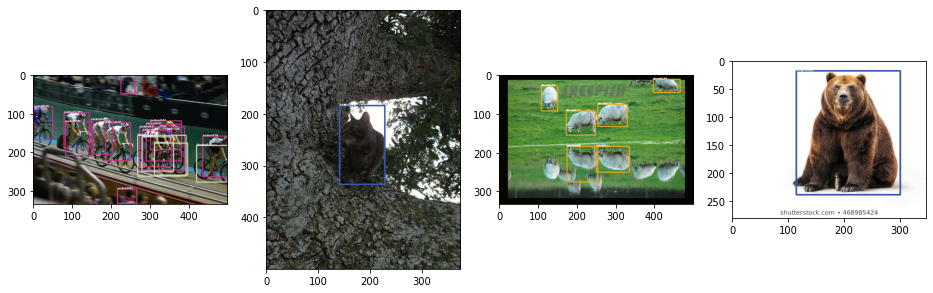

In [9]:
plt.figure(figsize=(16, 12))

for (img, classe, confidence, box)  in zip(IMG_PATHS, classes_id, confidences, boxes):
    image = mpimg.imread(img)
    draw_bounding_box(image, classe, confidence, box)
    plt.subplot(2, 4, IMG_PATHS.index(img)+1)
    plt.imshow(image)

In [11]:
for (img, classe, confidence)  in zip(IMG_PATHS, classes_id, confidences):
    print('#'*30)
    print('predictions on', img)
    for c_id, cfd in zip(classe, confidence):
        label = str(classes[c_id])
        conf = '%.2f' % cfd
        # Get the label for the class name and its confidence
        text = '%s:%s' % (label, conf)
        print(text)

##############################
predictions on ./images/img1.jpg
person:0.76
person:0.72
person:0.68
person:0.67
person:0.64
person:0.56
person:0.54
person:0.53
person:0.52
person:0.51
person:0.51
person:0.50
bicycle:0.59
bicycle:0.58
bicycle:0.57
bicycle:0.55
##############################
predictions on ./images/img2.jpg
bear:0.62
##############################
predictions on ./images/img3.jpg
bird:0.58
sheep:0.79
sheep:0.74
sheep:0.69
sheep:0.57
sheep:0.56
sheep:0.52
##############################
predictions on ./images/img4.jpg
bear:0.85


In [12]:
# Imad El Hanafi